## Notebook for testing plots of the number concentration

In [64]:
# imports from packages

#import pandas as pd
import xarray as xr
#import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
#import cartopy.crs as ccrs
#import cartopy.feature as creature
import glob
import os
#import sys # to test parts of code with sys.exit()
#import math
#import seaborn as sns

import data_selection
import create_vars
import lat_2band_select

#import numb_conc # functions relating to number concenctration calculations
#import plots


In [65]:
# --- Global formatting/settings/variables

sample_rate = 1 # alternatives: 1 s, 5 s, 12 s.

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

In [66]:
# --- Data import

main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed' # regular path
file_struct = f'/microphy_{sample_rate}s*.nc' # structure of cip text-file names

# get all the .nc files in the main path
files = glob.glob(main_path + file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]


ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight

In [67]:
# Main selection of data
pre_ds, info = data_selection.preselect_ds(ds) # do preselection with default values (T>-30, lat>70)
incloud_ds, incloud_desc = data_selection.sel_incloud_values(pre_ds) # select incloud values with default method (LWC_TWC_th)

# Get short and long descriptions
short_desc = info[0]+'_'+ incloud_desc[0]
long_desc = info[1]+incloud_desc[1]

In [68]:
# --- Preparations for altitude based plots

# need to add altitude binning information(based on in-cloud values9
incloud_ds, altitude_bins, bin_labels = create_vars.add_alt_bins(incloud_ds) # add altitude binning information

In [59]:
def lat_2band_select(lat_bands, ds):
    """Function to create masks for two latitude bands defined by the latitudes in lat_bands
      Parameters
    ----------
    ds
        xarray dataset with all microphy values
    lat_bands
        array of 3 values: lat_min, lat_mid, lat_max, defining the edges of the two lat bands

    Returns
    -------
    lat_mask_north
        mask to select values in ds that is within the northern latitude band
    lat_mask_south
        mask to select values in ds that is within the southern latitude band
    count_dict
        dictionary with following information:
            - count_south: number of observations in the southern region
            - count_north: number of observations in the northern region
            - lat_bands: array of the latitudes used to define the two regions

    """

    lat_min = lat_bands[0] # unpack lat selection
    lat_mid = lat_bands[1] # unpack lat selection
    lat_max = lat_bands[2] # unpack lat selection

    # count number of values between different latitudes and add to dictionary
    lat_values = ds['lat'].values  # Access the latitude coordinate
    
    count_dict = {'count_south': ((lat_values >= lat_min) & (lat_values <= lat_mid)).sum().item(),
                  'count_north': ((lat_values >= lat_mid) & (lat_values <= lat_max)).sum().item(),
                 'lat_bands': lat_bands}

    #return count_dict
    # Compute the boolean masks for latitude conditions
    lat_mask_north = (ds['lat'].values < lat_max) & (ds['lat'].values >= lat_mid)
    lat_mask_south = (ds['lat'].values < lat_mid) & (ds['lat'].values >= lat_min)

    # Example of filtering a dataset on masks
    #ds_filtered_north = ds.where(lat_mask_north, drop=True)
    #ds_filtered_south = ds.where(lat_mask_south, drop=True)

    #print(f'number of values in 2 bands defined by {lat_bands}:')
    #print(f'count_south: {len(ds_filtered_south.lat)},count_north: {len(ds_filtered_north.lat)}')
    
    return lat_mask_north, lat_mask_south, count_dict


In [69]:
# Mapping variables and set region

# dataset coordinate limits
lon_min = incloud_ds.lon.values.min() 
lon_max = incloud_ds.lon.values.max()
lat_min = incloud_ds.lat.values.min() 
lat_max = incloud_ds.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# --- Split for southern marine, northern marine and land datasets (in cloud)

# set lat-bands as boundaries for regions (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# Get the mask to use to select northern and southern band data
lat_mask_north, lat_mask_south, set_val_count_dict = create_vars.lat_2band_select(lat_bands, ds)

# set the value of region based on the two masks
incloud_ds['region'] = xr.where(lat_mask_north, 'north', xr.where(lat_mask_south, 'south', 'none'))

# drop values where region is 'none'
no_region_mask = (incloud_ds['region']=='none').compute()
ds_incloud = incloud_ds.where(~no_region_mask, drop=True)

AttributeError: module 'create_vars' has no attribute 'lat_2band_select'

In [63]:
ds_incloud

<xarray.Dataset> Size: 9TB
Dimensions:                 (time: 27054, region: 90768, Vector64: 64,
                             Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 216kB 2022-03-22T11:37:39 ....
    lat                     (time) float32 108kB 70.13 70.2 70.2 ... 74.95 74.95
    lon                     (time) float32 108kB 20.4 20.38 ... 20.88 20.88
    alt                     (time) float32 108kB 3.865e+03 3.864e+03 ... 887.3
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 (time) <U7 758kB 'IS22-02' 'IS22-02' ... 'IS22-11'
    altitude_bin            (time) int64 216kB 3750 3750 3750 ... 750 750 750
  * region                  (region) <U5 2MB 'south' 'south' ... 'south' 'south'
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/73)
    base_time               (time, region) datetime64[ns] 20GB 2022-03-22T11:...
    utc_time                (time, region) float64 20GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    TAS                     (time, region) float32 10GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    MIDBINS                 (time, Vector64, region) float32 629GB dask.array<chunksize=(9914, 64, 90768), meta=np.ndarray>
    ACTIVETIME              (time, region) float32 10GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    SA                      (time, Vector64, region) float32 629GB dask.array<chunksize=(9914, 64, 90768), meta=np.ndarray>
    ...                      ...
    TAS reduce              (time, region) float32 10GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    TAS correction factor   (time, region) float64 20GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    Number Conc corr        (time, region) float64 20GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    LWC corr                (time, region) float64 20GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    SV                      (time, region) float32 10GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
    SV_CDP                  (time, region) float32 10GB dask.array<chunksize=(9914, 90768), meta=np.ndarray>
Attributes:
    date_modified:            2025-05-26
    Joint sample rate (sek):  1.0

In [34]:
def numb_conc_plot_same(ax, ds_n, ds_s, cat_text):
    import numb_conc # number concentration functions

    #handles and labels for legends
    h_hist = []
    l_hist = []
    
    # Get the normalized values for plotting (from functions in numb_conc)
    n_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_n)
    n_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_n)
    s_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_s)
    s_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_s)

    # plot histogram based on normalized data and binning size information for CDP and CIP
    # North
    # exclude the 4 first bins of cdp (lower than 6 microns)
    h0  = ax.hist(ds_n['Size'].values[:3], weights = n_cdp_part_norm.values[:3], bins=ds_n['Size'].values[:3], label = "CDP north", 
            histtype='step', alpha = 0.7, color='grey')
    h1  = ax.hist(ds_n['Size'].values[3:], weights = n_cdp_part_norm.values[3:], bins=ds_n['Size'].values[3:], label = "CDP north", 
            histtype='step', alpha = 0.7, linewidth = 2, color='deepskyblue')
    
    h_hist.append(h1[2][0])
    l_hist.append('CDP North')
    
    midbins = ds_n['MIDBINS'].values
    weights = n_cip_part_norm.values
    h2 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:3], label="CIP North", color='grey', histtype='step', alpha=0.3)# Plot first three bins in grey
    h3 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP North", color='lightskyblue', linewidth = 2, histtype='step', alpha = 0.5)
    h_hist.append(h3[2][0])
    l_hist.append('CIP North')
    
    # --- calculate mean number concentration from the histogram 
    # - CDP
    prod_val_count_cdp = ds_n['Size'].values*n_cdp_part_norm.values
    tot_sum = prod_val_count_cdp[3:].sum()
    counts= n_cdp_part_norm.values[3:]
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l1 = ax.axvline(mean_size_cdp, color='deepskyblue', linestyle='dashed', linewidth=2, label=f'CDP North: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = n_cip_part_norm.values*ds_n['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = n_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l2 = ax.axvline(mean_size_cip, color='lightskyblue', linestyle='dashed', linewidth=2, label=f'CIP North: {mean_size_cip:.2f} $\mu$m')

    # South
    h4 = ax.hist(ds_s['Size'].values[3:], weights = s_cdp_part_norm.values[3:], bins=ds_s['Size'].values[3:], label = "CDP South", 
            histtype='step', alpha = 0.7,linewidth = 2, color = 'red')
    h7 = ax.hist(ds_s['Size'].values[:3], weights = s_cdp_part_norm.values[:3], bins=ds_s['Size'].values[:3], label = "CDP South", 
            histtype='step', alpha = 0.7, color = 'grey')
    h_hist.append(h4[2][0])
    l_hist.append('CDP South')
    
    midbins = ds_s['MIDBINS'].values
    weights = s_cip_part_norm.values
    h5 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:4], label="CIP South", color='grey', histtype='step', alpha=0.3)# Plot first three bins in grey
    h6 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP South", color = 'salmon', linewidth = 2, histtype='step', alpha = 0.5)
    h_hist.append(h6[2][0])
    l_hist.append('CIP South')
    h_hist.append(h5[2][0])
    l_hist.append('ignore 3 first bins \n of CIP and CDP)')
    
    # --- calculate mean number concentration from the histogram
    # - CDP
    prod_val_count_cdp = ds_s['Size'].values*s_cdp_part_norm.values
    tot_sum = prod_val_count_cdp[3:].sum()
    counts= s_cdp_part_norm.values[3:]
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l3 = ax.axvline(mean_size_cdp, color='red', linestyle='dashed', linewidth=2, label=f'CDP South: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = s_cip_part_norm.values*ds_s['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = s_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l4 = ax.axvline(mean_size_cip, color='salmon', linestyle='dashed', linewidth=2, label=f'CIP South: {mean_size_cip:.2f} $\mu$m')
   
    
    # set labels, titles and legends for subplots
    ax.set_ylabel('dN/dlogDp (#/$m^4$)', fontsize=16)
    ax.set_xlabel('Size ($\mu$m)',fontsize = 16)
    ax.set_title(cat_text, fontsize=18)

    # first legend:
    legend1 = ax.legend(handles=h_hist,labels = l_hist, loc='upper right', title='Size distribution', fontsize = 12, title_fontsize=12)
    ax.add_artist(legend1)

    #second legend:
    legend2 = ax.legend(handles=[l1,l2,l3,l4], loc = 'center right', title='Mean size', fontsize = 12,title_fontsize=12)
    ax.add_artist(legend2)

NameError: name 'north_top_ds' is not defined

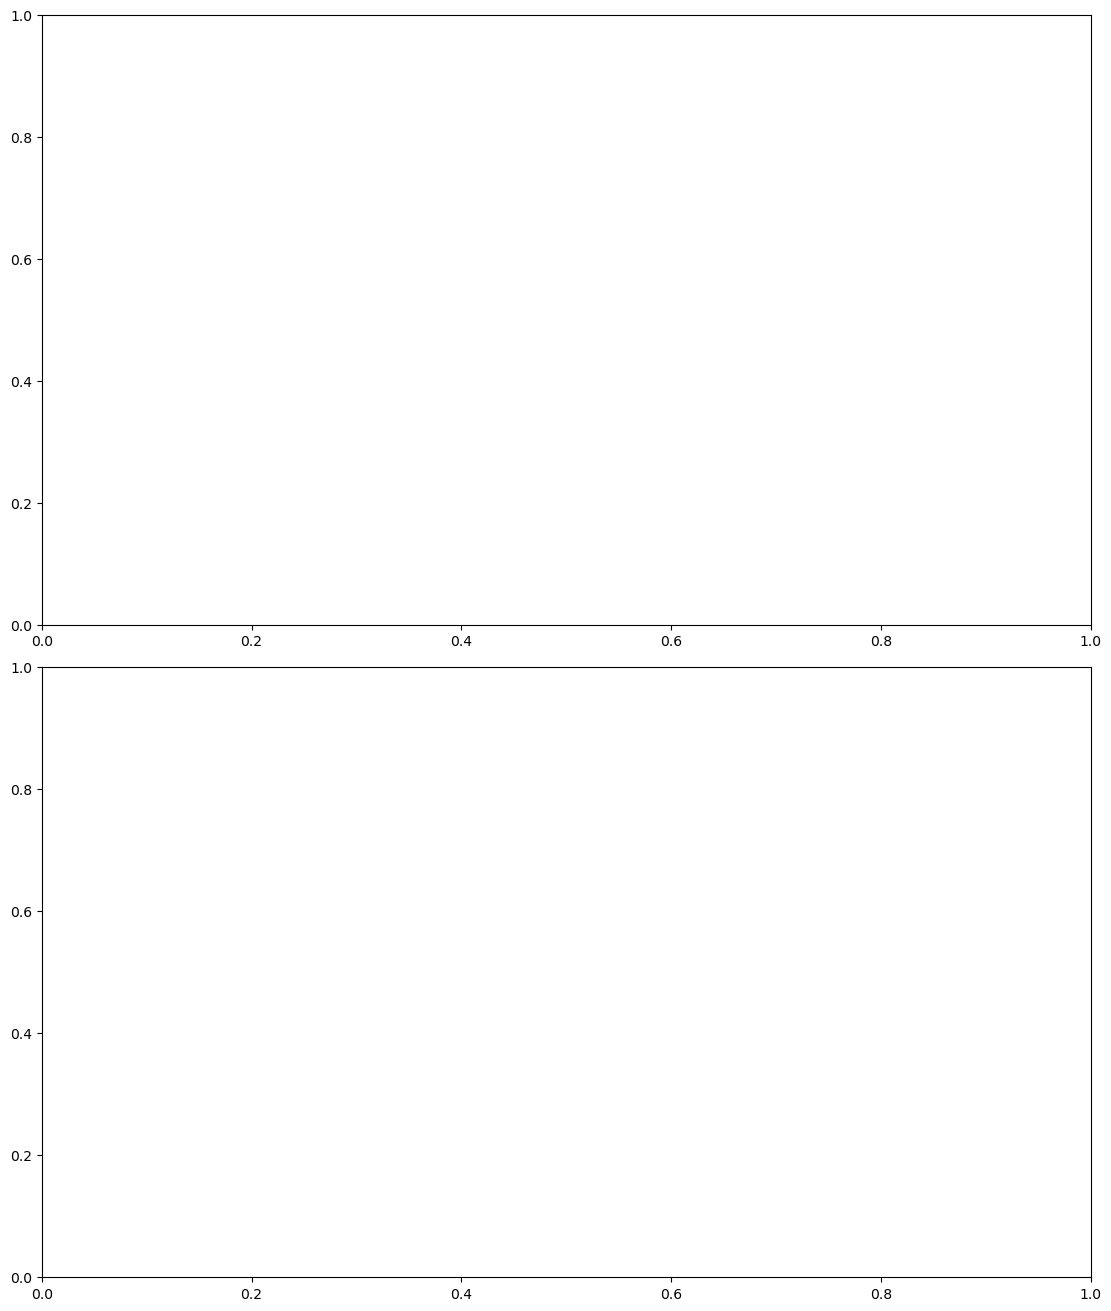

In [35]:
##### --- Plotting number concentrations in same plot (top and bulk)
### removing the values of cip that is below 6 um

fig, ax = plt.subplots(2, 1, figsize=(11, 13), layout="constrained", sharey=True)

# Top layer
numb_conc_plot_same(ax[0], north_top_ds, south_top_ds, f'Top layer of cloud (N:{n_top_list[0]}m, S:{s_top_list[0]}m)')

# Bulk layers
numb_conc_plot_same(ax[1], north_bulk_ds, south_bulk_ds, f'Bulk of cloud (N:{n_bulk_list[0]}-{n_bulk_list[-1]}m, S:{s_bulk_list[0]}-{s_bulk_list[-1]}m)')


# --- Subplot settings
for ax in ax.ravel():  # Flatten the array of axes and iterate
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.grid(True)
    #ax.label_outer()  # This method hides only labels in the inner axes; keep it commented out to show labels
    ax.yaxis.set_tick_params(which='both', labelleft=True)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
#plt.suptitle(f'Number concentration in 300m altitude layers per region (North marine, South marine) \n \
#            Pre-selection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.suptitle(f'Number concentration in 300m altitude layers \n per region (Northern marine, Southern marine)', fontsize=20)
plt.savefig(save_path+f'{th_method}/Ntjoint_Latitude_bands_2layer_rem3bins{th_method}{preopt}.png') # Save to
plt.show()